In [ ]:
import random
from datetime import timedelta

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import implicit
from scipy.sparse import csr_matrix

import warnings
warnings.simplefilter('ignore')

DATA_DIR = 'data'
SEED = 27
np.random.seed(SEED)
random.seed(SEED)

In [27]:
def get_data():
    """Читает все parquet‑файлы в Polars."""
    return (
        pl.read_parquet(f'{DATA_DIR}/test_users.pq').select(pl.all().shrink_dtype()),
        pl.read_parquet(f'{DATA_DIR}/clickstream.pq' ).select(pl.all().shrink_dtype()),
        pl.read_parquet(f'{DATA_DIR}/events.pq'     ).select(pl.all().shrink_dtype()),
        pl.read_parquet(f'{DATA_DIR}/cat_features.pq').select(pl.all().shrink_dtype()),
        pl.read_parquet(f'{DATA_DIR}/text_features.pq').select(pl.all().shrink_dtype()),
    )

def split_train_val(df_clickstream, df_events, days=7):
    """Последние <days> суток — валидация."""
    border = df_clickstream['event_date'].max() - timedelta(days=days)

    df_train = df_clickstream.filter(pl.col('event_date') <= border)
    df_val   = df_clickstream.filter(pl.col('event_date') >  border).select(['cookie','node','event'])

    df_val = (df_val
              .join(df_train, on=['cookie','node'], how='anti')
              .filter(pl.col('event')
                      .is_in(df_events.filter(pl.col('is_contact')==1)['event'].unique()))
              .filter(pl.col('cookie').is_in(df_train['cookie'].unique()))
              .filter(pl.col('node'  ).is_in(df_train['node'  ].unique()))
              .unique(['cookie','node']))
    return df_train, df_val


def gen_cookie_features(df, features_to_top = ("surface","platform","location","category")):
    """Возвращает таблицу cookie‑фичей."""
    # events / contacts
    base = (df.with_columns(pl.count().over('cookie').alias('events'))
              .filter(pl.col('is_contact')==1)
              .group_by('cookie')
              .agg([pl.count().alias('contacts'),
                    pl.first('events')])
              .with_columns((pl.col('contacts')/pl.col('events'))
                            .alias('contact_rate'))
              .fill_null(0))
    # recency
    last_evt = df.group_by('cookie').agg(pl.col('event_date').max().alias('last'))
    max_date = df['event_date'].max()
    recency  = last_evt.with_columns(((max_date - pl.col('last')).dt.total_days())
                                     .alias('recency'))
    # top‑«любимые» значения
    top_tbl = df.select('cookie').unique()
    for f in features_to_top:
        tmp = (df.group_by(['cookie',f]).agg(pl.count().alias('cnt'))
                 .sort(['cookie','cnt'], descending=True)
                 .group_by('cookie')
                 .agg(pl.first(f).alias(f'top_{f}')))
        top_tbl = top_tbl.join(tmp, on='cookie', how='left')

    return (top_tbl.join(base, on='cookie', how='left')
                   .join(recency.select(['cookie','recency']), on='cookie', how='left')
                   .fill_null(0))


def gen_node_features(df, df_cat):
    """Фичи объявления (node)."""
    # events / contacts
    base = (df.with_columns(pl.count().over('node').alias('events'))
              .filter(pl.col('is_contact')==1)
              .group_by('node')
              .agg([pl.count().alias('contacts'),
                    pl.first('events')])
              .with_columns((pl.col('contacts')/pl.col('events'))
                            .alias('contact_rate'))
              .fill_null(0))
    # уникальные items
    items = df_cat.group_by('node').agg(pl.col('item').n_unique().alias('items_cnt'))
    return base.join(items, on='node', how='left').fill_null(0)

def get_labels(df_val, df_cands):
    pos = df_val.select(['cookie','node']).with_columns(pl.lit(1).alias('label'))
    return (df_cands.join(pos, on=['cookie','node'], how='left')
                    .with_columns(pl.col('label').fill_null(0)))

def fit_als(df_train, params):
    """Обучает ALS, возвращает (model, mappings, sparse‑матрицу)."""
    u2i = {u:i for i,u in enumerate(sorted(df_train['cookie'].unique()))}
    n2i = {n:j for j,n in enumerate(sorted(df_train['node'  ].unique()))}
    i2n = {j:n for n,j in n2i.items()}

    rows = [u2i[c] for c in df_train['cookie']]
    cols = [n2i[n] for n in df_train['node'  ]]
    mat  = csr_matrix((np.ones(len(rows)), (rows, cols)),
                      shape=(len(u2i), len(n2i)))
    model = implicit.als.AlternatingLeastSquares(
        iterations     = params['als_iterations'],
        factors        = params['als_factors'],
        regularization = params['als_regularization'],
        alpha          = params['als_alpha'],
        num_threads=0, random_state=SEED)
    model.fit(mat)

    return model, mat, u2i, i2n

def recommend_als(model, mat, u2i, i2n, users, N):
    idx = [u2i[c] for c in users]
    recs, scores = model.recommend(userid=idx, user_items=mat[idx],
                                   N=N, filter_already_liked_items=True)
    return pl.DataFrame({
        'cookie': np.repeat(users, N),
        'node'  : np.concatenate([[i2n[j] for j in r] for r in recs]),
        'als_score': np.concatenate(scores)
    })
    
def recall_candidates(df_val, df_cands):
    """Recall набора кандидатов (до ранжирования)."""
    df_true = df_val.select(['cookie','node']).unique()
    df_hit  = (df_true
               .join(df_cands.select(['cookie','node']), how='inner', on=['cookie','node']))
    per_user = (df_true.group_by('cookie').agg(pl.count().alias('true_cnt'))
                .join(df_hit.group_by('cookie').agg(pl.count().alias('hit_cnt')),
                      on='cookie', how='left')
                .with_columns((pl.col('hit_cnt').fill_null(0)/pl.col('true_cnt'))
                              .alias('recall')))
    return per_user['recall'].mean()

def recall_at(df_true, df_pred, k=40):
    """Recall@k на валидации после ранжирования."""
    return (df_true[['cookie','node']]
            .join(df_pred.group_by('cookie').head(k)
                          .with_columns(value=1)[['cookie','node','value']],
                  how='left', on=['cookie','node'])
            .select([pl.col('value').fill_null(0), 'cookie'])
            .group_by('cookie')
            .agg((pl.col('value').sum()/pl.col('value').count()).alias('rec'))
            ['rec'].mean())

In [5]:
df_test, df_click, df_events, df_cat, df_text = get_data()

# train/val split →   df_train  (история)  +  df_val_true (реальные контакты 14 дней)
df_train, df_val_true = split_train_val(df_click, df_events)

In [9]:
df_train = df_train.to_pandas()
df_train

,cookie,item,event,event_date,platform,surface,node
0,0,19915558,17,2025-02-05 02:30:59,3,2,115659
1,0,2680232,17,2025-01-24 21:16:57,3,2,115829
2,1,4247649,17,2025-01-29 23:00:58,2,2,7
3,1,2171135,17,2025-01-17 19:23:29,2,2,214458
4,1,6830678,17,2025-02-09 13:17:03,2,2,15
...,...,...,...,...,...,...,...
57032056,149999,4486457,17,2025-01-29 10:41:51,2,11,51162
57032057,149999,4999183,17,2025-01-20 12:23:47,2,2,71511
57032058,149999,25999164,17,2025-01-24 14:26:57,2,2,71514
57032059,149999,12138732,17,2025-02-12 13:11:42,2,2,51162


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57032061 entries, 0 to 57032060
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   cookie      int32         
 1   item        int32         
 2   event       int8          
 3   event_date  datetime64[ns]
 4   platform    int8          
 5   surface     int8          
 6   node        uint32        
dtypes: datetime64[ns](1), int32(2), int8(3), uint32(1)
memory usage: 1.2 GB


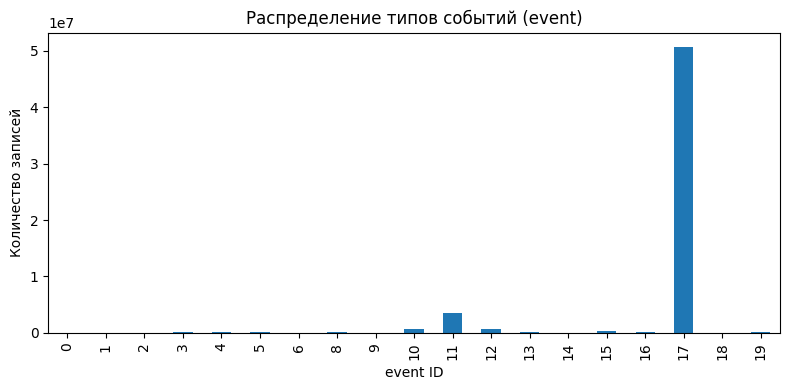

In [11]:
event_counts = df_train['event'].value_counts().sort_index()

plt.figure(figsize=(8,4))
event_counts.plot(kind='bar')
plt.title('Распределение типов событий (event)')
plt.xlabel('event ID')
plt.ylabel('Количество записей')
plt.tight_layout()
plt.show()

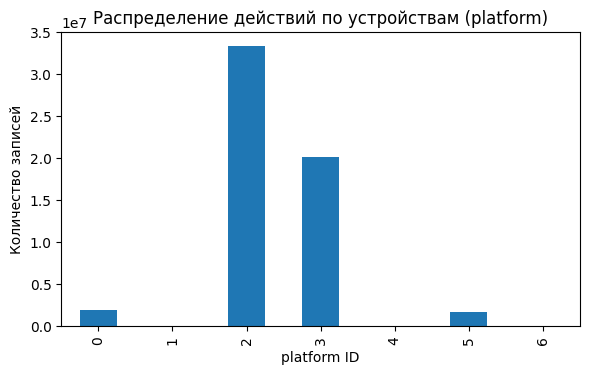

In [12]:
platform_counts = df_train['platform'].value_counts().sort_index()

plt.figure(figsize=(6,4))
platform_counts.plot(kind='bar')
plt.title('Распределение действий по устройствам (platform)')
plt.xlabel('platform ID')
plt.ylabel('Количество записей')
plt.tight_layout()
plt.show()

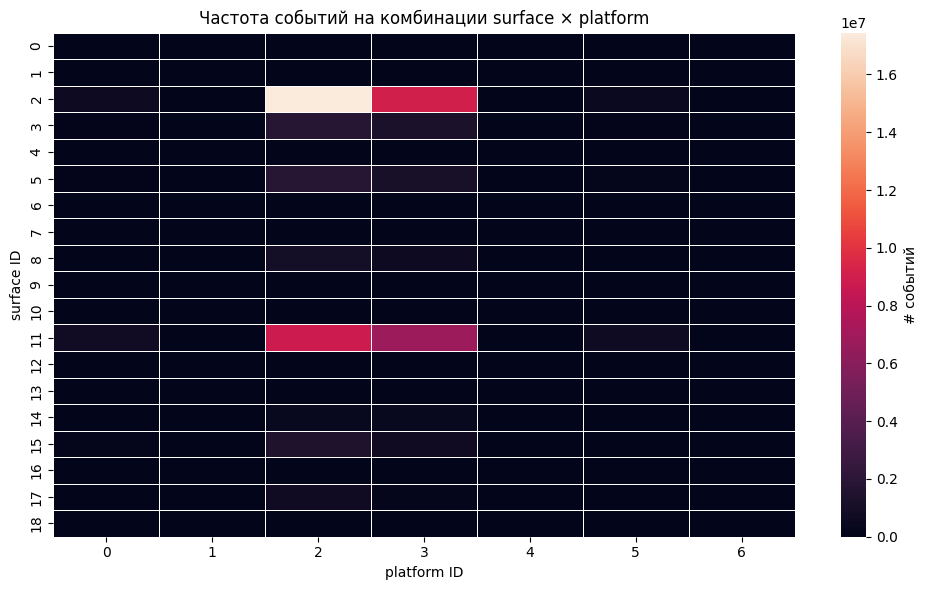

In [15]:
pivot = (
    df_train
    .groupby(['surface','platform'], observed=True)
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, linewidths=.5, cbar_kws={'label':'# событий'})
plt.title('Частота событий на комбинации surface × platform')
plt.xlabel('platform ID')
plt.ylabel('surface ID')
plt.tight_layout()
plt.show()

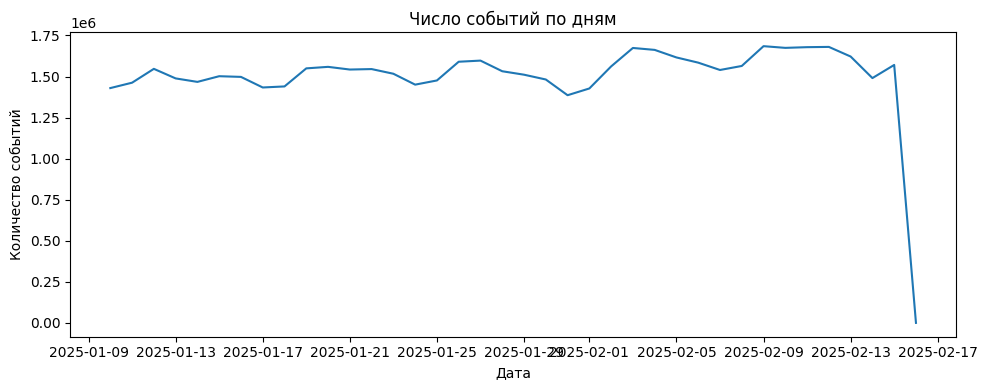

In [16]:
daily_counts = df_train.groupby(df_train['event_date'].dt.date).size()

plt.figure(figsize=(10,4))
daily_counts.plot()
plt.title('Число событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.tight_layout()
plt.show()


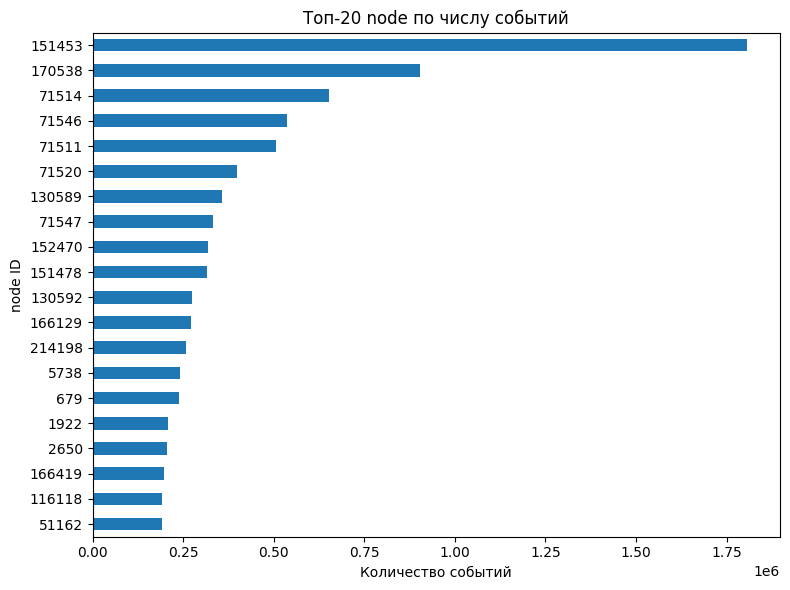

In [17]:
top_nodes = (
    df_train['node']
    .value_counts()
    .head(20)
    .sort_values(ascending=True)
)

plt.figure(figsize=(8,6))
top_nodes.plot(kind='barh')
plt.title('Топ-20 node по числу событий')
plt.xlabel('Количество событий')
plt.ylabel('node ID')
plt.tight_layout()
plt.show()


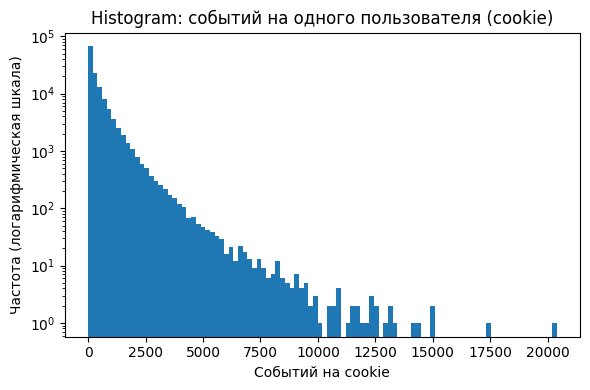

In [20]:
cookie_event_counts = df_train.groupby('cookie').size()

plt.figure(figsize=(6,4))
cookie_event_counts.plot(kind='hist', bins=100, logy=True)
plt.title('Histogram: событий на одного пользователя (cookie)')
plt.xlabel('Событий на cookie')
plt.ylabel('Частота (логарифмическая шкала)')
plt.tight_layout()
plt.show()


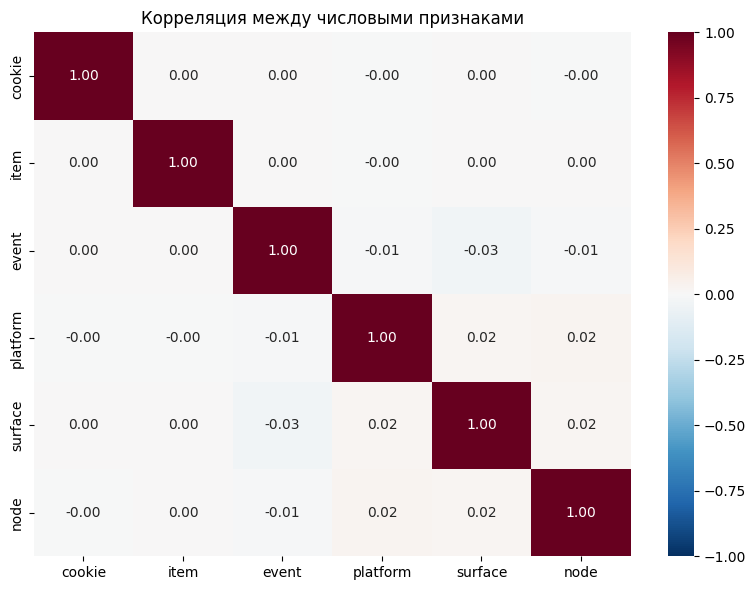

In [21]:
num_cols = ['cookie', 'item', 'event', 'platform', 'surface', 'node']
corr = df_train[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Корреляция между числовыми признаками')
plt.tight_layout()
plt.show()


### Быстрый разбор EDA-графиков  

| № | График | Что видно | Что это значит для моделирования |
|---|--------|-----------|----------------------------------|
| **1** | **Распределение `event`** | Тип 17 ≈ 90 % всех записей; остальные типы на порядки реже. | Очень сильный дисбаланс: если признак «event» идёт в модель «как есть», он почти не несёт информации (почти всегда 17). Возможно стоит либо отбросить, либо сгруппировать редкие типы, либо отдельно рассматривать «не-17». |
| **2** | **Распределение `platform`** | Львиную долю составляют 2 (≈60 %) и 3 (≈35 %); 0 и 5 встречаются редко, остальные почти отсутствуют. | Фактически «две площадки» → можно закодировать как бинарный флаг «mobile / desktop» (если 2 — Android, 3 — iOS/-web и т.п.). Редкие значения лучше объединить. |
| **3** | **Heatmap `surface × platform`** | Самый трафиковый экран — `surface=2`; на нём больше всего действий с `platform=2`. Второй по объёму – `surface=11`, причём трафик почти поровну между платформами 2 и 3. | Поведение пользователей различается по комбинации «экран+устройство». Эти две оси полезно использовать совместно (feature crossing) либо добавить признак «major_surface». |
| **4** | **Daily trend** | Плавный рост активности с 8 янв до ~14 фев; обвал в самом конце — очевидный эффект усечения выборки (последний день неполный). | В данных нет ярко выраженных недельных циклов, но есть общий рост интереса к платформе. При построении временных фичей важно учесть обрезку последнего дня. |
| **5** | **Top-20 `node`** | Длинный «хвост»: у лидера (151 453) ~1.8 млн событий, затем резкий спад. | Классификация по `node` будет сильно несбалансированной: пару сотен топ-групп дают большую часть трафика, тысячи остальных — редкие. Хорошая идея — таргетировать топ-N, а хвост агрегировать. |
| **6** | **Событий на `cookie` (лог-гистограмма)** | Плотное распределение со степенным хвостом: большинство пользователей ≤ 100–200 событий, но есть «киты» с >10 000. | Полезно нормировать/лог-трансформировать счётчики действий, применять методы, устойчивые к выбросам, либо отсекать сверхактивных при обучении. |
| **7** | **Корреляционная матрица** | Все взаимные корреляции ≈ 0. | Числовые id-поля независимы друг от друга: их надо рассматривать как категориальные, а не числовые. Простая линейная модель без one-hot/embeddings не извлечёт информацию. |


In [26]:
PARAMS = dict(
    als_iterations = 20,
    als_factors    = 150,
    als_regularization = 0.1,
    als_alpha      = 5.0,
    als_N_cand     = 300,
)

als_model, als_mat, u2i, i2n = fit_als(df_train, PARAMS)
df_cands = recommend_als(
    als_model, als_mat, u2i, i2n,
    users=df_val_true['cookie'].unique().to_list(),
    N=PARAMS['als_N_cand']
)
print("Candidate recall:", recall_candidates(df_val_true, df_cands))

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Candidate recall: 0.4041235982162798


In [28]:
df_full_join = (df_click.join(df_events, on='event', how='left')
                          .join(df_cat.select(['item','location','category']),
                                on='item', how='left'))
cookie_f = gen_cookie_features(df_full_join)
node_f   = gen_node_features(df_full_join, df_cat)

df_cands = (df_cands
            .join(cookie_f, on='cookie', how='left')
            .join(node_f  , on='node'  , how='left')
            .fill_null(0))

# 4) Лейблы 0/1 и раздельный сплит по cookie
df_cands_lab = get_labels(df_val_true, df_cands)

In [30]:
df_cands_lab = df_cands_lab.to_pandas()
df_cands_lab

,cookie,node,als_score,top_surface,top_platform,top_location,top_category,contacts,events,contact_rate,recency,contacts_right,events_right,contact_rate_right,items_cnt,label
0,0,115834,1.024010,2,3,2348,19,17,314,0.05414,0,1272,54611,0.023292,19731,0
1,0,1907,0.962169,2,3,2348,19,17,314,0.05414,0,2268,84005,0.026998,26648,0
2,0,214236,0.958878,2,3,2348,19,17,314,0.05414,0,1041,20029,0.051975,6668,0
3,0,116118,0.954478,2,3,2348,19,17,314,0.05414,0,5126,230850,0.022205,83582,0
4,0,214235,0.925453,2,3,2348,19,17,314,0.05414,0,1114,38131,0.029215,8269,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10541095,149997,130800,0.332154,11,2,5803,51,20,329,0.06079,1,212,24043,0.008818,4128,0
10541096,149997,171373,0.332106,11,2,5803,51,20,329,0.06079,1,22,1137,0.019349,257,0
10541097,149997,186139,0.330239,11,2,5803,51,20,329,0.06079,1,15,1310,0.011450,132,0
10541098,149997,231977,0.330197,11,2,5803,51,20,329,0.06079,1,22,659,0.033384,167,0


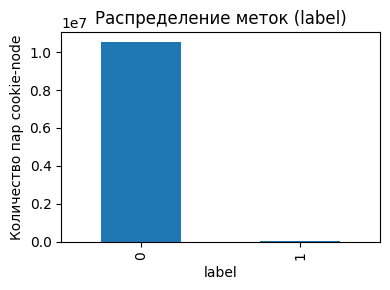

In [32]:
label_counts = df_cands_lab['label'].value_counts().sort_index()

plt.figure(figsize=(4,3))
label_counts.plot(kind='bar')
plt.title('Распределение меток (label)')
plt.xlabel('label')
plt.ylabel('Количество пар cookie-node')
plt.tight_layout()
plt.show()


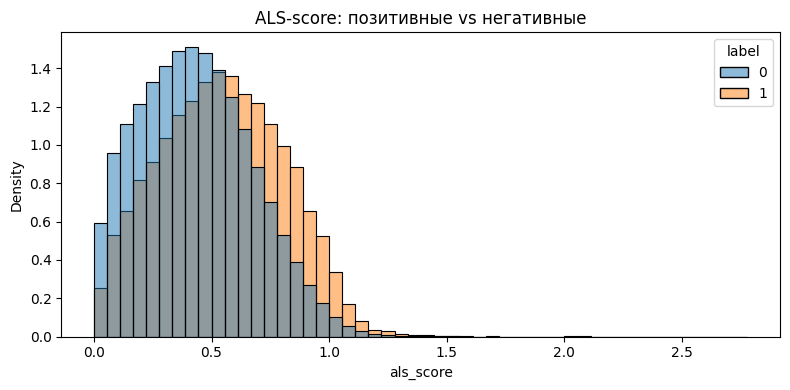

In [33]:
plt.figure(figsize=(8,4))
sns.histplot(data=df_cands_lab, x='als_score', hue='label', bins=50, stat='density', common_norm=False)
plt.title('ALS-score: позитивные vs негативные')
plt.xlabel('als_score')
plt.tight_layout()
plt.show()


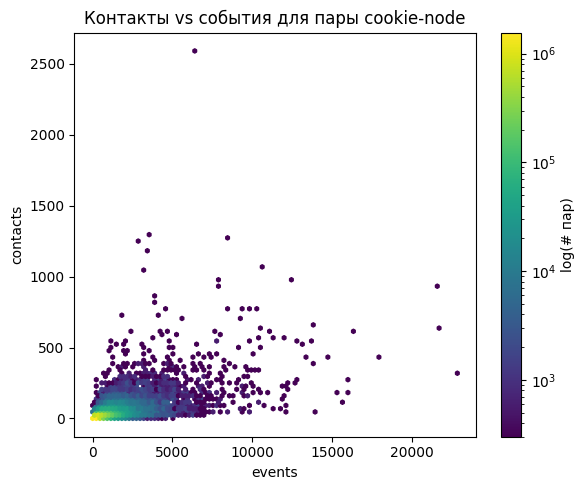

In [34]:
plt.figure(figsize=(6,5))
plt.hexbin(df_cands_lab['events'], df_cands_lab['contacts'], bins='log')
plt.colorbar(label='log(# пар)')
plt.xlabel('events')
plt.ylabel('contacts')
plt.title('Контакты vs события для пары cookie-node')
plt.tight_layout()
plt.show()


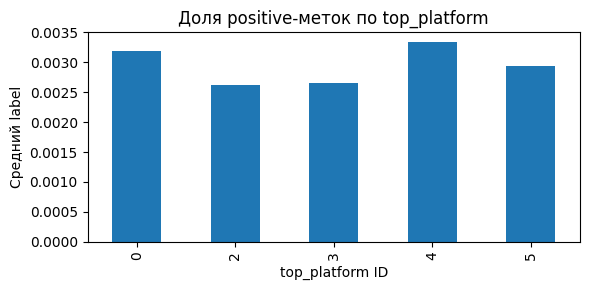

In [35]:
platform_ctr = (
    df_cands_lab.groupby('top_platform')['label']
    .mean()
    .sort_index()
)

plt.figure(figsize=(6,3))
platform_ctr.plot(kind='bar')
plt.title('Доля positive-меток по top_platform')
plt.xlabel('top_platform ID')
plt.ylabel('Средний label')
plt.tight_layout()
plt.show()


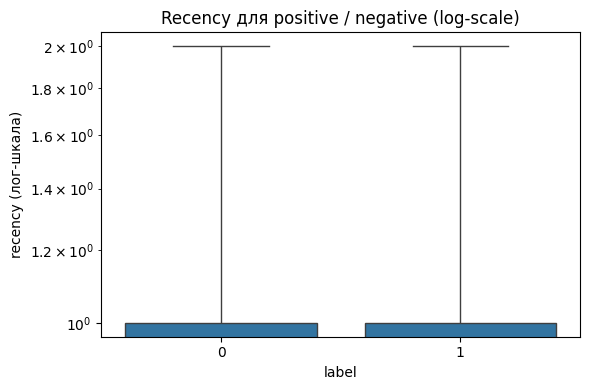

In [36]:
plt.figure(figsize=(6,4))
sns.boxplot(x='label', y='recency', data=df_cands_lab, showfliers=False)
plt.yscale('log')
plt.title('Recency для positive / negative (log-scale)')
plt.xlabel('label')
plt.ylabel('recency (лог-шкала)')
plt.tight_layout()
plt.show()

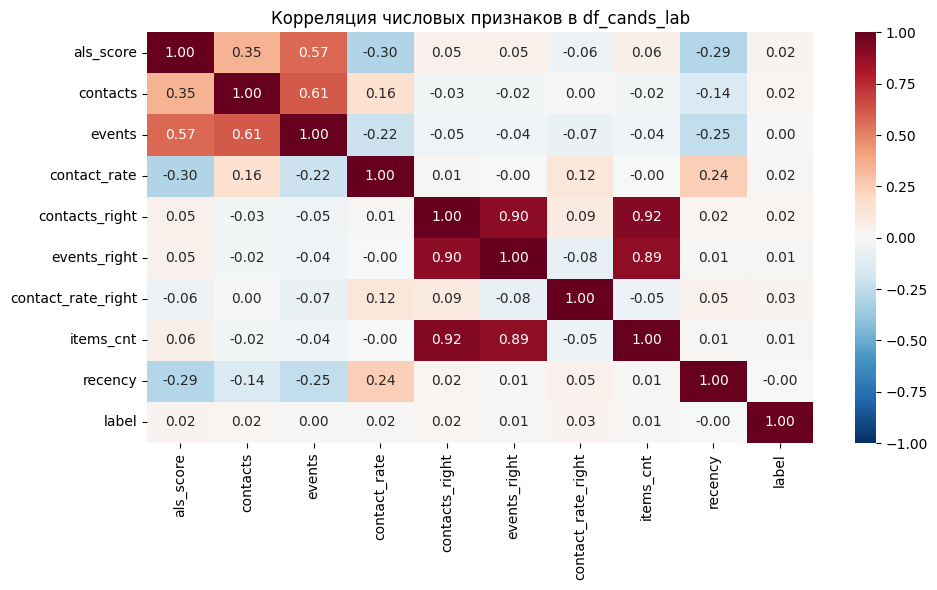

In [37]:
num_cols = [
    'als_score','contacts','events','contact_rate',
    'contacts_right','events_right','contact_rate_right',
    'items_cnt','recency','label'
]

import seaborn as sns
corr = df_cands_lab[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Корреляция числовых признаков в df_cands_lab')
plt.tight_layout()
plt.show()

### Анализ отобранных кандидатов  

| № | График | Что видно | Что это значит для задачи |
|---|--------|-----------|---------------------------|
| **1** | **Баланс классов (`label`)** | Доля положительных примеров («1») — доли процента (≈ 0.2 %), почти весь датасет — «0». | Крайний дисбаланс ⇒ нужен stratifed sampling / class weights / focal-loss. Метрика соревнования, скорее всего, на это тоже настроена. |
| **2** | **`als_score`: positive vs negative** | Распределения смещены: positive-кривую тянет вправо, медиана выше ≈ 0.7 – 0.8, но области перекрываются. | `als_score` — сильный, но не самодостаточный сигнал: хорош для начального ранжирования, но понадобится ансамбль/доп-фичи для отделения «хвоста» перекрытия. |
| **3** | **`events` vs `contacts` (hexbin)** | Масса точек сконцентрирована в зоне «несколько сотен событий & < 50 контактов». Связь сублинейная — с ростом событий контакты растут, но медленнее; есть редкие экстремалы. | Информацию лучше лог-трансформировать или использовать rate-фичи (`contacts / events`). Сильные выбросы стоит отсекать/каппировать. |
| **4** | **`recency` для positive/negative (box, log-scale)** | Распределения почти совпадают; медиана у обоих — самый свежий интервал (1). Опоры слегка короче у positive, но различие минимально. | «Свежесть» пары почти не отличает классы → сама по себе фича слабая; возможно надо нормировать на cookie-уровне или рассчитать decaying-score. |
| **5** | **Корреляционная матрица** | Плотная связка *events↔contacts* (0.61) и правых аналогов (0.9+). `als_score` положительно коррелирует с events/contacts, отрицательно – c `contact_rate`. Все связи с `label` ≈ 0.02. | Числовые признаки в линейном виде почти не объясняют target ⇒ нужны сложные модели, нелинейные взаимодействия и/или фичи из других источников (cookie-, node-, time-context). |
| **6** | **(`events`, `contacts`) — ещё раз наглядно** | (Дублирующий график подтвердил вывод № 3.) | — |

> **Итого:** датасет тяжёлый дисбаланс, «сырые» счётчики тесно коррелируют, а `als_score` — главный, но недостаточный предиктор. Модели придётся улавливать слабые сигналы и взаимодействия, а выбор метрик/симметричных сэмплов будет критичен.
